# Case de estudo: Dados sobre turbinas eólicas na Turquia em 2018

Fonte: https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset


## Importando Bibliotecas

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Lendo o arquivo e renomeando as colunas para ficar mais fácil de escrever o código

In [6]:
df = pd.read_csv('T1.csv')
#df.head(10)
#df.dtypes
#df.describe()
#df.info()

df.columns = ['date', 'active_power', 'wind_speed', 'theoretical_power', 'wind_direction']
df.head()

,date,active_power,wind_speed,theoretical_power,wind_direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


## Convertendo a coluna Date/Time para o tipo datetime e colocando como index

PS: isso se torna possível apenas porque pegamos dados de apenas uma turbina, então o registro de data pode ser usado como chave primária

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,active_power,wind_speed,theoretical_power,wind_direction
date,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


## Plotando gráfico de correlação entre as variáveis do dataframe

Text(0.5, 1.0, 'Correlation Heatmap')

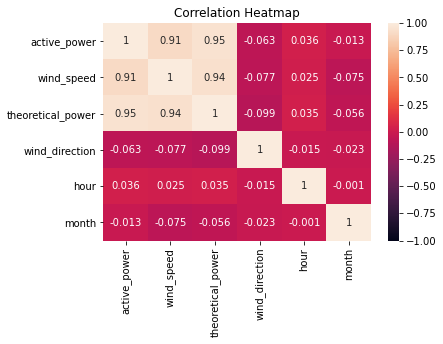

In [19]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap')

## Plotando gráfico de correlação com a variável potencia real

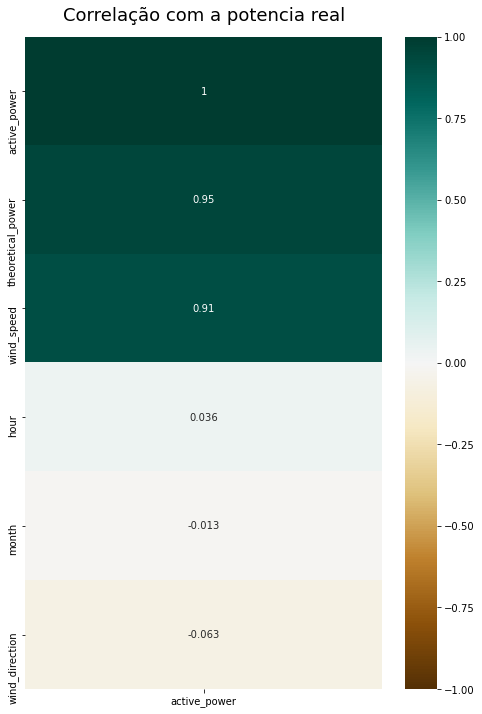

In [22]:
df.corr()[['active_power']].sort_values(by='active_power', ascending=False)
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(df.corr()[['active_power']]
                      .sort_values(by='active_power', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlação com a potencia real', fontdict={'fontsize':18}, pad=16);

## Plotando os dados da curva teórica vs curva real

[Text(0.5, 0, 'Wind Speed(m/s)'), Text(0, 0.5, 'Power(kW)')]

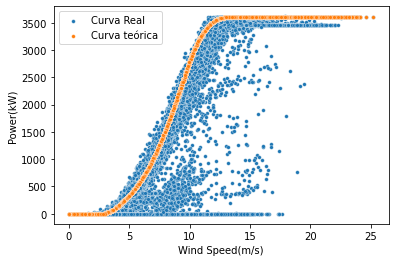

In [23]:
grafico = sns.scatterplot(data=df, x='wind_speed', y='active_power', label='Curva Real', s=14)
grafico = sns.scatterplot(data=df, x='wind_speed', y='theoretical_power', label='Curva teórica', s=14)

grafico.set(xlabel='Wind Speed(m/s)', ylabel='Power(kW)')

## Criando "limites aceitáveis"

In [24]:
potencia_real= df['active_power'].tolist()
potencia_teorica = df['theoretical_power'].tolist()
potencia_max=[]
potencia_min=[]
dentro_limite = []

for potencia in potencia_teorica:
    potencia_max.append(potencia*1.05)
    potencia_min.append(potencia*0.95)

for indice, potencia in enumerate(potencia_real):
    if potencia>=potencia_min[indice] and potencia<=potencia_max[indice]:
        dentro_limite.append('Inside')
    elif potencia==0:
        dentro_limite.append('Zero')
    else:
        dentro_limite.append('Outside')
    
#print(dentro_limite.count('Inside')/len(dentro_limite))  #Output = 0.37, 37% está dentro do limite que determinamos

#Agora criamos uma nova coluna no dataframe que diz se está dentro ou fora do nosso limite 
df['Inside_Limit'] = dentro_limite



## Adicionando lista "dentro_limite" ao dataframe:

In [25]:
df['Inside_Limit'] = dentro_limite 
display(df)

,active_power,wind_speed,theoretical_power,wind_direction,hour,month,Inside_Limit
date,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,Outside
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,Outside
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,Outside
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,Outside
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,Outside
...,...,...,...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,23,12,Outside
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,23,12,Outside
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,23,12,Outside


## Plotando o gráfico com os limites:

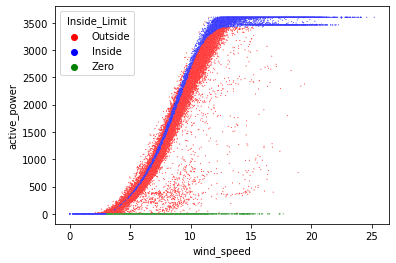

In [28]:
cores = {'Inside':'blue','Outside':'red','Zero':'green'}
grafico = sns.scatterplot(data=df, x='wind_speed', y='active_power',hue='Inside_Limit', s=1, palette=cores)

## Plotando o gráfico de energia real por cada hora do dia

<AxesSubplot:title={'center':'Average of Active Power of each hours'}, xlabel='hour'>

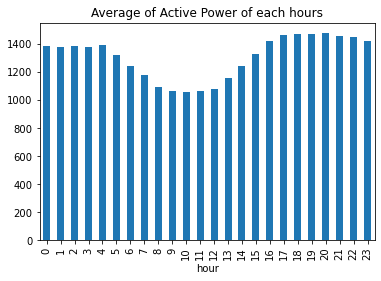

In [10]:
dates = df.index
hours = [date.hour for date in dates]
df['hour'] = hours

df.groupby('hour').mean().active_power.plot(kind='bar', title='Average of Active Power of each hours')

## Plotando o gráfico de energia real por cada mes do ano

<AxesSubplot:title={'center':'Average of Active Power of each month'}, xlabel='month'>

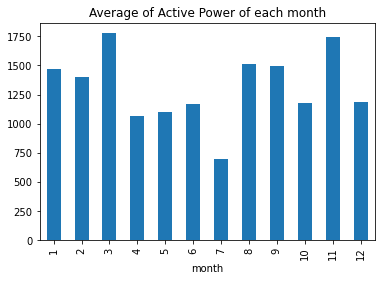

In [13]:
months = [date.month for date in df.index]
df['month'] = months

df.groupby('month').mean().active_power.plot(kind='bar', title='Average of Active Power of each month')

## Plotando o mesmo gráfico, mas adicionando cores para os meses com mais/menos energia

Text(0, 0.5, 'Active Power(kW)')

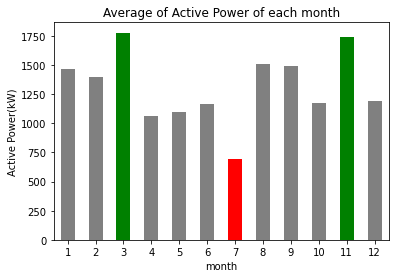

In [18]:
color = list(np.full(12, 'grey'))
color[2], color[10] = 'green', 'green'
color[6] = 'red'

df.groupby('month').mean().active_power.plot(kind='bar', title='Average of Active Power of each month', 
                                            color=color, rot=0)
plt.ylabel('Active Power(kW)')

## Criando uma coluna da perda de energia (valor teórico - valor real)

In [29]:
df['loss'] = df['theoretical_power'] - df['active_power']
df.head()

,active_power,wind_speed,theoretical_power,wind_direction,hour,month,Inside_Limit,loss
date,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,Outside,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,Outside,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,Outside,84.523429
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,Outside,96.481664
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,Outside,111.052276


## Criando uma coluna para mostrar qual a direção que está o vento

Com isso poderemos investigar qual é o fator que o vento tem sobre a perda de energia

In [ ]:
#Primeiro criamos uma função que irá retornar em qual direção está o vento com base no wind_direction
def direction(x):
    if x > 348.75 or x < 11.25 : return 'N'
    if x < 33.75: return 'NNE'
    if x < 56.25: return 'NE'
    if x < 78.75: return 'ENE'
    if x < 101.25: return 'E'
    if x < 123.75: return 'ESE'
    if x < 146.25: return 'SE'
    if x < 168.75: return 'SSE'
    if x < 191.25: return 'S'
    if x < 213.75: return 'SSW'
    if x < 236.25: return 'SW'
    if x < 258.75: return 'WSW'
    if x < 281.25: return 'W'
    if x < 303.75: return 'WNW'
    if x < 326.25: return 'NW'
    else: return 'NNW'

df['direction'] = df['wind_direction'].apply(direction)
df.groupby('direction').loss.sum().sort_values(ascending=False).plot(kind='bar', title='Total Power Loss(kWh)')

## Preparação para o modelo de Machine Learning - Data Wrangling

In [37]:
df_model = df.copy()
df_model.head()

,active_power,wind_speed,theoretical_power,wind_direction,hour,month,Inside_Limit,loss,direction
date,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,0,1,Outside,36.281117,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,0,1,Outside,66.148316,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,0,1,Outside,84.523429,W
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,0,1,Outside,96.481664,W
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,0,1,Outside,111.052276,W


## Limpeza dos dados
Primeira limpeza será das linhas que possuem um active_power negativo, o que é possível e normal na fisica, onde é possível se ter uma energia negativa por causa do atrito, mas como nós não iremos predizer os valores negativos de energia, podemos remover eles dos dados

Também iremos remover as linhas aonde o wind_speed é maior que 3m/s (o suficiente para gerar energia) e o active_power é 0, visto que esses valores podem representar momentos onde a turbina está parada para manutenção, ou algum outro motivo que irá atrapalhar o nosso modelo de ML

In [42]:
df_model = df_model[df_model.active_power > 0]

df_model = df_model[(df_model.wind_speed >= 3.5) & (df.theoretical_power != 0) & (df.active_power != 0)]

#Utilizamos o describe para validar as mudanças que realizamos
df_model.describe()

#Também é possível validar as mudanças vendo a diferença do número de linhas antes e depois do código 
number_of_rows_after = len(df_model.index)
number_of_rows_before = len(df.index)
#print(number_of_rows_before - number_of_rows_after) #Output = 12115

12115


<ipython-input-42-6a3e5f20d4e1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_model = df_model[(df_model.wind_speed >= 3.5) & (df.theoretical_power != 0) & (df.active_power != 0)]


## Construção do modelo SVM (Support Vector Machine)
O primeiro modelo será desenvolvido sem levar em conta o fator de tempo em cima das turbinas, iremos investigar se existe uma boa função matemática para verificar a energia real da turbina com base na direção do vento(wind_direction) e na velocidade do vento(wind_speed)

In [50]:
#Separamos as nossas features e o nosso target
X = df_model[['wind_direction', 'wind_speed']]
y = df_model['active_power']

#Separamos os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Criamos a pipeline 
pipe = make_pipeline(StandardScaler(), SVR())

r2_cv = cross_val_score(pipe, X_train, y_train, cv=5)
print(r2_cv)
print(np.mean(r2_cv))

[0.93799174 0.93968938 0.9344764  0.93593688 0.94096427]
0.9378117342582002


In [57]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# Train R2
print(f'Train R2: {pipe.score(X_train, y_train)}')

# Test R2, MSE, MAE
print(f'Test R2: {pipe.score(X_test, y_test)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_pred)}')

Train R2: 0.9424778369494117
Test R2: 0.9433690530798207
Test MAE: 156.06724587767155
Test MSE: 87636.53317823405


## Conclusão

.A média da energia gerada é maior em Março e Novembro, e é substancialmente menor em Julho, isso pode ser causado pelas condições climáticas, mas seria necessário investigar mais a fundo para aceitarmos ou rejeitarmos essa hipótese. <br>
.A velocidade de vento mínima para produzir energia é de 3m/s, porém existem momentos quando a turbina gera energia mesmo com a velocidade do vento menor que 3m/s <br>
.